## Introduction

Assignment:

**Predict whether a failure of a Scania Truck component is related to the air pressure system (APS) or not.**

Evaluation:

**The evaluation metric is the ROC-AUC score** 

Data:

A set of anonymized features that were collected from heavy Scania Trucks at everyday usage.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (cross_val_score, cross_validate, 
                                     GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (precision_recall_curve, confusion_matrix, 
                             classification_report, plot_roc_curve, recall_score, precision_score, 
                             f1_score, roc_auc_score)

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

import pickle

## Data

### Exploration

Read data from csv files into pandas dataframes. The csv files contain 20 lines of data description before the actual data table, so I am skipping those rows.

In [2]:
# Data has 20 rows of description at the start, missing values coded as 'na'

train = pd.read_csv('./data/aps_failure_training_set.csv', skiprows=20, na_values='na')
test = pd.read_csv('./data/aps_failure_test_set.csv', skiprows=20, na_values='na')

In [3]:
# class column is coded as 'pos' and 'neg', replacing with 1 and 0 to make it more suitable for modeling

train['class'].replace(['pos', 'neg'], [1,0], inplace=True)
test['class'].replace(['pos', 'neg'], [1,0], inplace=True)

In [4]:
train.shape

(60000, 171)

In [5]:
train.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,0.000000,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,1.000000,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


All columns are positive numbers. Ranges differ significantly. **Scaling will be necessary for distance-based models / transformations**

In [6]:
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    class   60000 non-null  int64  
 1    aa_000  60000 non-null  int64  
 2    ab_000  13671 non-null  float64
 3    ac_000  56665 non-null  float64
 4    ad_000  45139 non-null  float64
 5    ae_000  57500 non-null  float64
 6    af_000  57500 non-null  float64
 7    ag_000  59329 non-null  float64
 8    ag_001  59329 non-null  float64
 9    ag_002  59329 non-null  float64
 10   ag_003  59329 non-null  float64
 11   ag_004  59329 non-null  float64
 12   ag_005  59329 non-null  float64
 13   ag_006  59329 non-null  float64
 14   ag_007  59329 non-null  float64
 15   ag_008  59329 non-null  float64
 16   ag_009  59329 non-null  float64
 17   ah_000  59355 non-null  float64
 18   ai_000  59371 non-null  float64
 19   aj_000  59371 non-null  float64
 20   ak_000  55600 non-null  float64
 21   al_000  59

### Missing values

High number of null values in the data. Getting an idea percentage-wise per column:

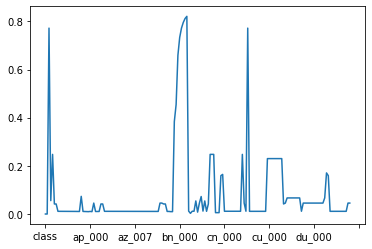

In [7]:
train.isna().mean().plot();

Based on this plot I decided to drop columns that have >20% missing values. Usually this decision would be based on some domain knowledge, but the columns here are anonymized. I will be imputing missing values, but doing so on columns that have too many missing values can reduce the variance in the data

In [8]:
dropped_columns = train.loc[:, train.isna().mean() > 0.2].columns

In [9]:
train.drop(columns=dropped_columns, inplace= True)
test.drop(columns=dropped_columns, inplace= True)

In [10]:
train.shape

(60000, 147)

### Dimensionality

High-dimensional data can negatively impact the performance of ML algorithms and increases the volume of data needed to make accurate predictions exponentially. 

Having this many features also makes me worry that there may be some multi-collinearity. This can cause problems (overfitting, affects statistical significance) in linear models especially and can be an indication that dimensionality reduction may be warranted. I will check for this first.

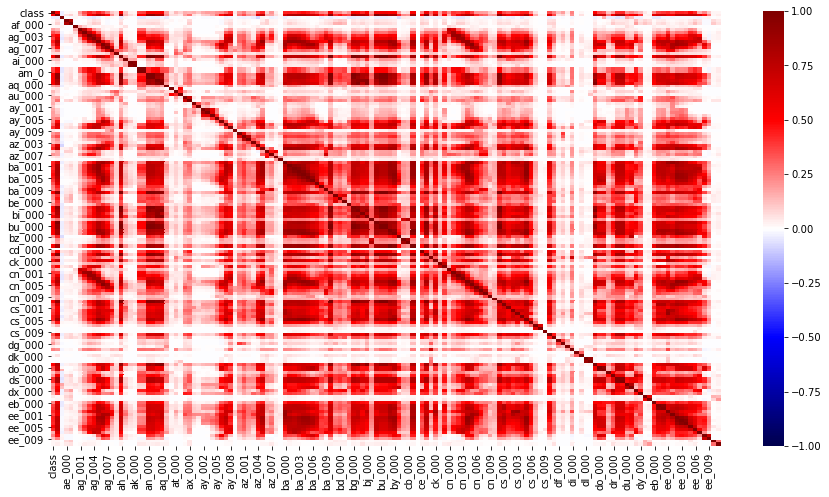

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

The heatmap shows very strong correlation between many of our features. This data can likely be represented in less dimensions than it currently has.

### Dimensionality reduction

In [12]:
X = train.drop(columns='class')
y = train['class']
X_test = test.drop(columns='class')
y_test = test['class']

Using Principal Component Analysis (PCA) to represent the data in less dimensions, while keeping at least 95% of variance of the data represented. This is a number that could be tuned if later results do not look good.

In [13]:
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_imputed)
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)
reduced = pca.transform(X_scaled)

In [14]:
# Check number of components necessary to reach 95% explained variance
pca.n_components_

71

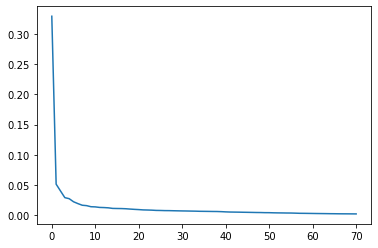

In [15]:
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)

If model efficiency becomes a problem, this graph shows that most of the explained variance falls inside the first 10 components. It would be possible to reduce the number of components and test model performance as a trade-off between efficiency (speed / memory) and performance (auc). For now, since I am focusing on maximizing performance, I will stick with 95% explained variance

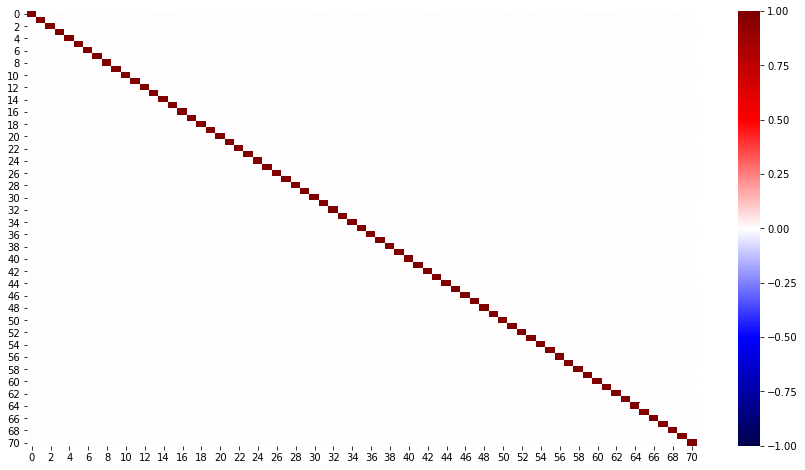

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap(pd.DataFrame(reduced).corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

No more collinearity should help linear models perform better and less features can make model execution more efficient.

### PCA impact baseline
Creating a baseline score to test impact of dimensionality reduction.

In [17]:
baseline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
round(np.mean(cross_val_score(baseline, X, y, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)),3)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   30.8s finished


0.97

In [18]:
pca_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), PCA(n_components = 0.95), LogisticRegression())
round(np.mean(cross_val_score(pca_pipeline, X, y, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)),3)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   31.9s finished


0.965

The difference is small enough to believe that PCA is a viable option to test

### Class imbalance

Checking for class imbalance in the data

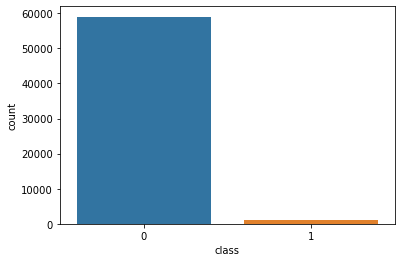

In [19]:
sns.countplot(x='class', data=train);

In [20]:
train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [21]:
train['class'].value_counts()[1]/train['class'].value_counts()[0]

0.01694915254237288

The positive class (failure is related to APS) makes up **less than 2%** of the data set. It will be worth testing oversampling to try and improve model performance.

## Model selection

From the previous sections it is clear that this is a high-dimensional and very imbalanced dataset. I will test multiple classification algorithms as well as PCA and oversampling to find the preprocessing steps and model(s) that perform well on this data. Then I will select the best performing ones and tune them for optimal performance in the next section.

I am **excluding KNN and SVM** here, since they are known to perform poorer on larger (high dimension) datasets. KNN also has to save the entire dataset as part of the .fit step and SVM is computationally intensive, especially when using kernel tricks.

In [22]:
estimators = {'Logistic Regression': LogisticRegression(), 'Random Forest': RandomForestClassifier(), 'Naive Bayes': GaussianNB(), 'XGBoost': XGBClassifier()}

For each model I will test performance on the original data (with imputed null values), PCA reduced data, oversampled data and reduced + oversampled data. I created a function to get the performance for each of these combinations for a single estimator.

I use 10-fold cross-validation to assess performance and generalization of the result.

In [23]:
def get_score(X, y, name, estimator):
    '''
    Get cross validation scores for multiple pipelines with single estimator
    Inputs:
    X, y: features, target
    name: string, name of estimator
    estimator: estimator object to be fed into pipeline
    '''
    imputed = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), estimator)
    oversampled = make_pipeline(SimpleImputer(strategy='median'),  
                                StandardScaler(), SMOTE(sampling_strategy=0.15), estimator)
    reduced = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), 
                            PCA(n_components = 0.95), estimator)
    reduced_oversampled = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), 
                                        SMOTE(sampling_strategy=0.15), PCA(n_components = 0.95), estimator)
    
    pipelines = {'imputed': imputed, 'oversampled': oversampled, 'reduced': reduced, 
                 'reduced_oversampled': reduced_oversampled}
    
    for key, pipe in pipelines.items():
        score = cross_val_score(pipe, X, y, scoring='roc_auc', cv=10, verbose=0, n_jobs=-1)
        print(f'{name} {key} roc_auc: {score.mean():.3f} (+/- {score.std():.3f})')

In [24]:
for key, estimator in estimators.items():
    get_score(X, y, key, estimator)

Logistic Regression imputed roc_auc: 0.970 (+/- 0.014)
Logistic Regression oversampled roc_auc: 0.969 (+/- 0.017)
Logistic Regression reduced roc_auc: 0.965 (+/- 0.012)
Logistic Regression reduced_oversampled roc_auc: 0.970 (+/- 0.016)
Random Forest imputed roc_auc: 0.987 (+/- 0.007)
Random Forest oversampled roc_auc: 0.989 (+/- 0.005)
Random Forest reduced roc_auc: 0.984 (+/- 0.006)
Random Forest reduced_oversampled roc_auc: 0.988 (+/- 0.005)
Naive Bayes imputed roc_auc: 0.963 (+/- 0.009)
Naive Bayes oversampled roc_auc: 0.961 (+/- 0.013)
Naive Bayes reduced roc_auc: 0.970 (+/- 0.004)
Naive Bayes reduced_oversampled roc_auc: 0.968 (+/- 0.006)
XGBoost imputed roc_auc: 0.990 (+/- 0.004)
XGBoost oversampled roc_auc: 0.991 (+/- 0.005)
XGBoost reduced roc_auc: 0.988 (+/- 0.005)
XGBoost reduced_oversampled roc_auc: 0.988 (+/- 0.005)


## Tuning


Random Forest and XGBoost outperformed the other models without any tuning. I'll pick those two to to try and tune the hyperparameters some more to improve performance even further. Random Forest seems to benefit slightly from oversampling and XGBoost does best with just the base (imputed) data.

### Random Forest

For Random Forest I used an exhaustive grid search to find the optimal parameters.

In [25]:
rf = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler()), ('smote', SMOTE()), ('rf', RandomForestClassifier())])

In [26]:
params = {'smote__sampling_strategy': [0.15, 0.5, 1],
          'rf__max_depth': [2, 3, 5, 10],
          'rf__n_estimators': [50, 100, 200]}

In [27]:
rf_grid = GridSearchCV(rf, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=5)

In [28]:
rf_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imp',
                                        SimpleImputer(strategy='median')),
                                       ('sc', StandardScaler()),
                                       ('smote', SMOTE()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 3, 5, 10],
                         'rf__n_estimators': [50, 100, 200],
                         'smote__sampling_strategy': [0.15, 0.5, 1]},
             scoring='roc_auc')

In [29]:
rf_grid.best_estimator_

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('sc', StandardScaler()),
                ('smote', SMOTE(sampling_strategy=0.15)),
                ('rf', RandomForestClassifier(max_depth=10, n_estimators=200))])

In [30]:
rf_grid.best_score_

0.9889141101694916

In [31]:
rf_grid.best_params_

{'rf__max_depth': 10,
 'rf__n_estimators': 200,
 'smote__sampling_strategy': 0.15}

### XGBoost

For XGBoost there are so many parameters that an exhaustive grid search would take too long to run. I am using a randomized search here, which has been shown to yield similar (of not better) results in practice.

Using XGBoost in a pipeline with the randomizedsearchCV is tricky, so I will do the steps separately for the hyperparameter search. If this ends up as the final model I will fit using a pipeline again.

I am using early stopping to determine the optimal n_estimators and increase efficiency of the searchCV here.

In [32]:
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X)

In [33]:
xgb = XGBClassifier(n_estimators=1000)

In [34]:
params = {'xgb__max_depth': [2, 4, 6, 8, 10, 12],
          'xgb__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
          'xgb__min_child_weight': [1, 3, 5],
          'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 5],
          'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]}

In [35]:
xgb_searchcv = RandomizedSearchCV(xgb, cv=5, param_distributions=params, n_iter=20, n_jobs=-1)
xgb_searchcv.fit(X_imputed, y, early_stopping_rounds= 10, eval_set=[[X_imputed, y]], eval_metric='auc') 

/Users/stephan/anaconda3/envs/scania_challenge/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { xgb__colsample_bytree, xgb__gamma, xgb__learning_rate, xgb__max_depth, xgb__min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.93635
[1]	validation_0-auc:0.96429
[2]	validation_0-auc:0.96778
[3]	validation_0-auc:0.96989
[4]	validation_0-auc:0.97857
[5]	validation_0-auc:0.98040
[6]	validation_0-auc:0.98154
[7]	validation_0-auc:0.98228
[8]	validation_0-auc:0.98645
[9]	validation_0-auc:0.98805
[10]	validation_0-auc:0.98817
[11]	validation_0-auc:0.99021
[12]	validation_0-auc:0.99169
[13]	validation_0-auc:0.99176
[14]	validation_0-auc:0.99186
[15]	validation_0-auc:0.99197
[16]	validation_0-auc:0.99338
[17]	validation_0-auc:0.99692

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=1000...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [36]:
xgb_searchcv.best_params_

{'xgb__min_child_weight': 3,
 'xgb__max_depth': 2,
 'xgb__learning_rate': 0.25,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 1}

In [37]:
xgb_searchcv.best_score_

0.9942333333333332

## Final model

The XGBoost model performed the best, so I will take the results from the hyperparameter search and train my final model, testing it on the held out test data.

At this point I will also start looking at a secondary metric. roc_auc is the asked for metric, but to actually use this model I will need to set a threshold for final predictions.

In this case, a false positive means that the cause of a failure is falsely identified as the APS, causing a possibly unnecessary check. A false negative means that the APS is missed as the true cause of the failure, which could cause a faulty truck to be cleared or many unnecessary checks in other areas. I believe a false negative is more costly (or causes higher risk), so I will be looking at recall as my second metric.

In [48]:
xgb = XGBClassifier(max_depth=2, learning_rate=0.25, gamma=0.3, min_child_weight=3, colsample_bytree=1)

With this final model in place I validate the performance one more time to check for overfitting.

In [49]:
cross_validate(xgb, X_imputed, y, scoring=['roc_auc', 'recall'], cv=10, n_jobs=-1, return_train_score=True)

{'fit_time': array([79.56805801, 79.44554996, 79.55751872, 79.57435107, 86.04775691,
        86.28175211, 86.56240296, 86.57176018, 43.25029302, 43.17533278]),
 'score_time': array([0.14055204, 0.11215997, 0.13238716, 0.19899392, 0.18334889,
        0.18880081, 0.1781292 , 0.14538288, 0.06916404, 0.11610007]),
 'test_roc_auc': array([0.99385932, 0.99102712, 0.98717797, 0.99280678, 0.99094237,
        0.97757458, 0.98696017, 0.99509322, 0.99321186, 0.98599746]),
 'train_roc_auc': array([0.99523105, 0.99457587, 0.99526859, 0.99552903, 0.99537451,
        0.99608402, 0.99589969, 0.99471259, 0.99540173, 0.99542123]),
 'test_recall': array([0.74, 0.73, 0.73, 0.69, 0.75, 0.66, 0.65, 0.76, 0.63, 0.67]),
 'train_recall': array([0.78666667, 0.78222222, 0.77666667, 0.78111111, 0.77111111,
        0.78666667, 0.78444444, 0.78111111, 0.78444444, 0.78555556])}

Looking at roc_auc train vs test, there is some minor overfitting, but not to an extend that concerns me. I will keep this as my final model and create the pipeline that will allow me to save and use the model for predictions.

In [50]:
xgb_pipeline = make_pipeline(SimpleImputer(strategy='median'), XGBClassifier(max_depth=6, learning_rate=0.2, gamma=5, min_child_weight=3, colsample_bytree=0.9))
xgb_pipeline.fit(X, y, xgbclassifier__early_stopping_rounds= 10, xgbclassifier__eval_set=[[X_imputed, y]], xgbclassifier__eval_metric='auc')

/Users/stephan/anaconda3/envs/scania_challenge/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.94219
[1]	validation_0-auc:0.96327
[2]	validation_0-auc:0.96417
[3]	validation_0-auc:0.96929
[4]	validation_0-auc:0.96989
[5]	validation_0-auc:0.97587
[6]	validation_0-auc:0.97700
[7]	validation_0-auc:0.98164
[8]	validation_0-auc:0.98482
[9]	validation_0-auc:0.98547
[10]	validation_0-auc:0.98612
[11]	validation_0-auc:0.98713
[12]	validation_0-auc:0.98727
[13]	validation_0-auc:0.98731
[14]	validation_0-auc:0.98920
[15]	validation_0-auc:0.98973
[16]	validation_0-auc:0.98972
[17]	validation_0-auc:0.98979
[18]	validation_0-auc:0.99069
[19]	validation_0-auc:0.99077
[20]	validation_0-auc:0.99081
[21]	validation_0-auc:0.99096
[22]	validation_0-auc:0.99104
[23]	validation_0-auc:0.99111
[24]	validation_0-auc:0.99107
[25]	validation_0-auc:0.99321
[26]	validation_0-auc:0.99341
[27]	validation_0-auc:0.99345
[28]	validation_0-auc:0.99435
[29]	validation_0-auc:0.99437
[30]	validation_0-auc:0.99432
[31]	validation_0-auc:0.99513
[32]	validation_0-auc:0.99646
[33]	validation_0-au

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

### Threshold tuning

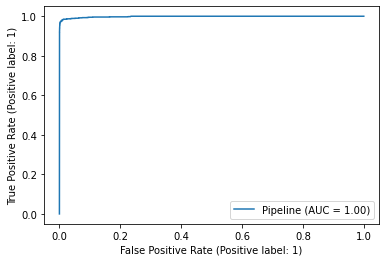

In [51]:
plot_roc_curve(xgb_pipeline, X, y)
plt.show();

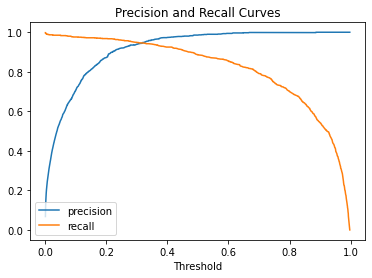

In [52]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y, xgb_pipeline.predict_proba(X)[:,1])
                                                                        
plt.figure()
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

Precision is high at low thresholds, but precision takes a sharp dive at really low thresholds. This graph means that the number of false positives goes up exponentially as the threshold is lowered. 

Setting the final threshold in a business setting would have to be decided with business stakeholders.

 **How many false positives would we accept to reduce the false negatives?**

 I will assume we want to get a low number of false negatives, but also keep the number of false positives at least somewhat in check.

### Running final model on test data

In [53]:
threshold = 0.05
y_proba_test = xgb_pipeline.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba_test)
y_pred_test = (y_proba_test > threshold)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(f'roc_auc: {roc_auc:.3f}')
print(f'recall: {recall:.3f} | precision: {precision:.3f} | f1: {f1:.3f}')

roc_auc: 0.996
recall: 0.941 | precision: 0.600 | f1: 0.733


Final roc_auc on the test dataset is **0.996**

Now we can have a look what the effect of the threshold looks like in a confusion matrix.

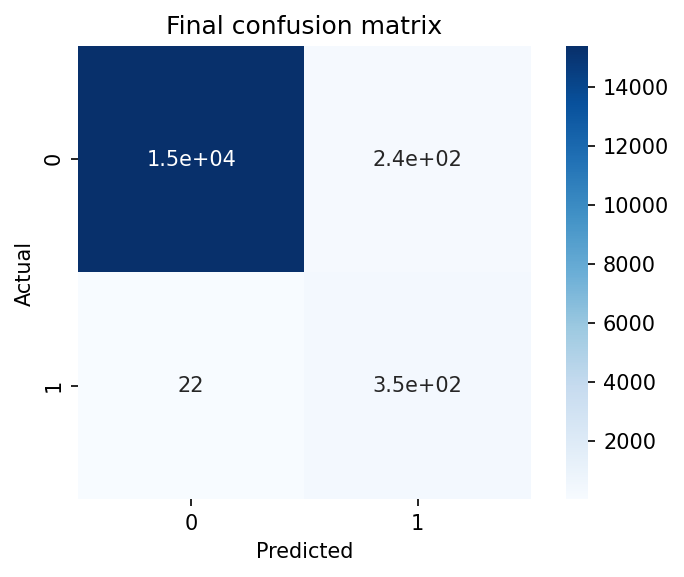

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=150)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final confusion matrix');

### Save model

Next I will save my final model for deployment.

In [55]:
file_name = 'final_model.pickle'
pickle.dump(xgb_pipeline, open(file_name, 'wb'))

### Feature importance

XGBoost has several methods to investigate feature importance, which can help gain some insight from the model. Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model.

It is important to note that these scores are estimates, but they give some interpretability to these ensemble methods.

The default feature importance in XGBoost uses 'weight', or the number of times a feature appears in a tree in the model. This can be problematic when using categorical data, especially with high cardinality, but in this case almost all features are numeric.

**Note** A quirk of XGBoost's feature importance is that it renames the features by the number they appeared. If the columns were not anonymized to start with, I would have displayed the feature names here.

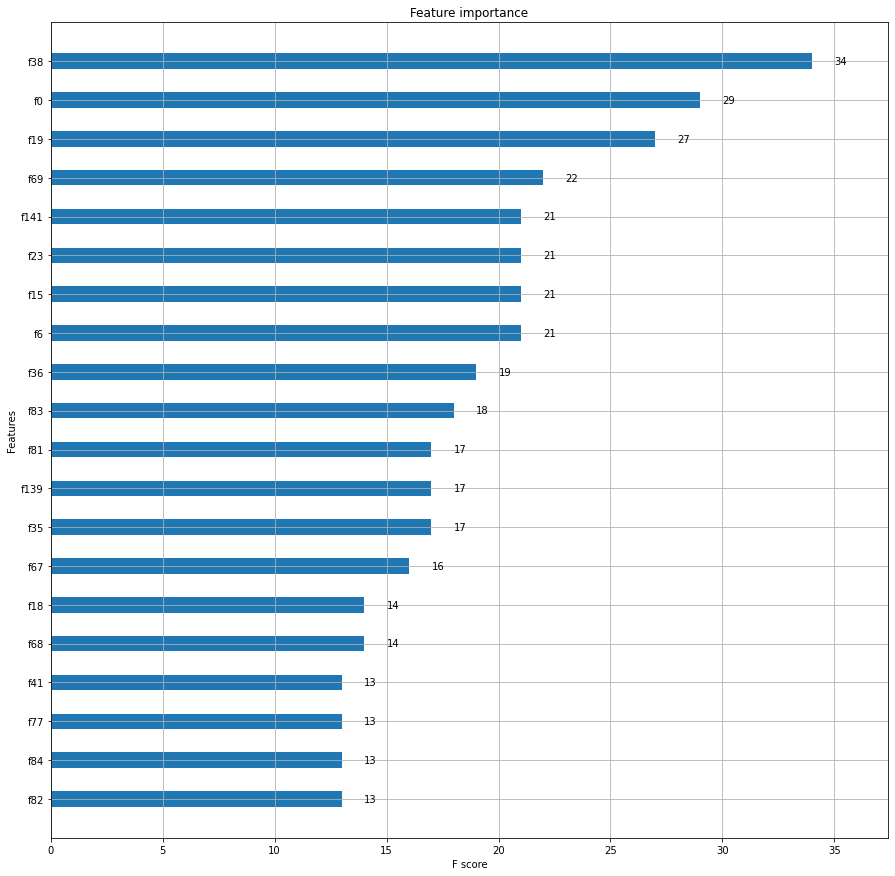

In [56]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
plot_importance(xgb_pipeline.named_steps['xgbclassifier'], ax=ax, max_num_features=20, importance_type='weight', height=0.4);

Another way to look at feature importance is to use 'gain', which calculates the average information gain of splits using the feature

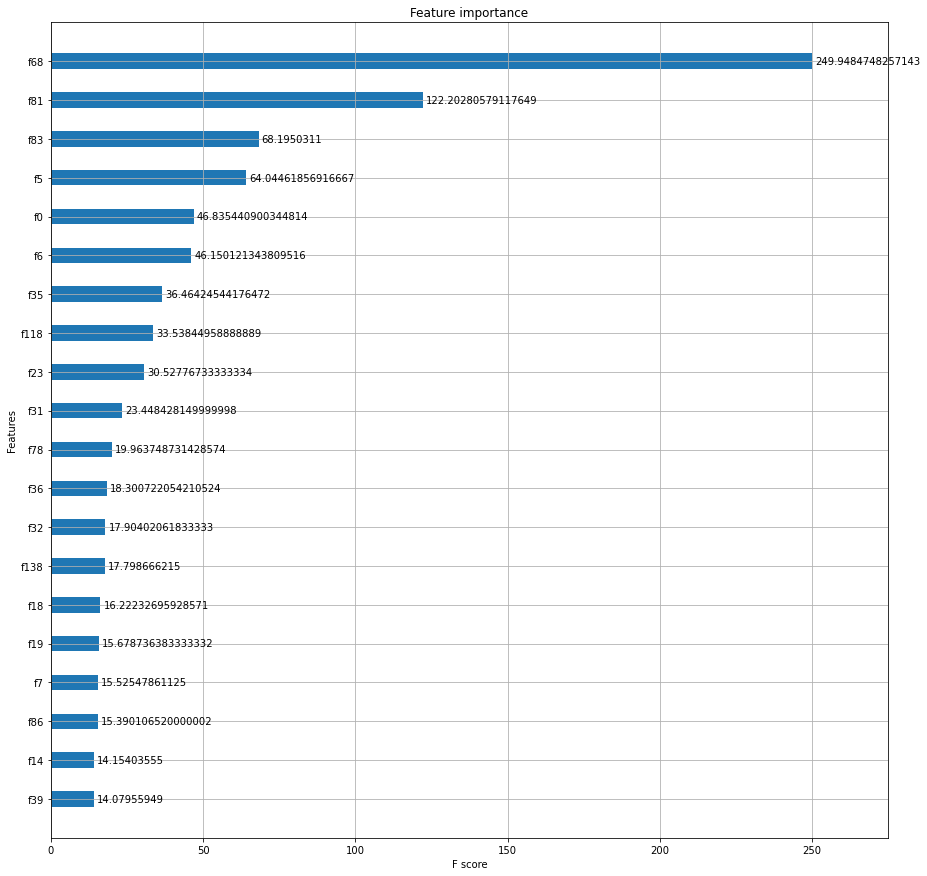

In [57]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
plot_importance(xgb_pipeline.named_steps['xgbclassifier'], ax=ax, max_num_features=20, importance_type='gain', height=0.4);